<a href="https://colab.research.google.com/github/hcgalvan/labodedatos/blob/main/modelos_unico_individuo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Trabajo Final Laboratorio de Datos - 2021 1er cuatrimestre
### **Tema: Clasificador de estado mental por ECB**
### Integrantes: Devia, Amalia; Galvan,Hugo; Palmucci, Matias; Ticona, María Belén
#### Pregunta: ¿Es posible lograr alcanzar un resultados similar al del paper original empleando modelos más sencillos e interpretables? | ¿Tomando ciertos componentes principales se lograra un mejor o peor *accuracy*?

#### Esquema de Procedimiento para responder la pregunta:
  

1.   Obtención del dataset completo [inserte link github]
2.   Split entre lote de testing y training
3.   Feature Selection mediante correlación de Pearson (una de las técnicas usadas en el trabajo original)
4.   [completar!]







## 0. Reproducibilidad del trabajo
Para que el trabajo sea reproducible, fijamos ciertas variables globales a considerar.

In [ ]:
import random
RANDOM_SEED = 1
random.seed(a=RANDOM_SEED)

## 1. Dataset 
El dataset se ha generado desde el siguiente [generador de feature desde EEG](https://github.com/jordan-bird/eeg-feature-generation), donde se toman determinadas feature por cada intervalo de 1 segundo de las señales de EEG empleando 4 sensores particulares.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np 
import matplotlib.pyplot as plt 
from scipy import stats
from numba import njit
import pandas as pd
import seaborn as sns
import time
from matplotlib.colors import ListedColormap
# definición de pipelines
from sklearn.pipeline import Pipeline
# feature selection and model
from sklearn.linear_model import LogisticRegression
# selección de modelos
from sklearn.model_selection import train_test_split
# normalización de datos
from sklearn.preprocessing import StandardScaler
# funciones para construir datasets sintéticos
from sklearn.datasets import make_moons, make_circles, make_classification
# clasificador: red neuronal (perceptron multicapa, 100 capas por defecto, activación por ReLu)
from sklearn.neural_network import MLPClassifier
# clasificador: KNN
from sklearn.neighbors import KNeighborsClassifier
# clasificador: support vector classifier
from sklearn.svm import SVC
# clasificador: árbol de decisión
from sklearn.tree import DecisionTreeClassifier
# clasificador: ensemble de árboles (random forest)
from sklearn.ensemble import RandomForestClassifier
# clasificador: árbol de decisión
from sklearn.model_selection import StratifiedKFold
# Modulos específicos para árboles de decisión
from sklearn.tree import plot_tree # Función para visualizar el árbol
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score


In [ ]:
filename = '/content/drive/MyDrive/Laboratorio de datos final/sujeto_A.csv'

In [ ]:
df = pd.read_csv(filename)
print("Cantidad de samples: {}\nCantidad de features: {}".format(df.shape[0], df.shape[1]))
df.head()

Cantidad de samples: 683
Cantidad de features: 989


,lag1_mean_0,lag1_mean_1,lag1_mean_2,lag1_mean_3,lag1_mean_d_h2h1_0,lag1_mean_d_h2h1_1,lag1_mean_d_h2h1_2,lag1_mean_d_h2h1_3,lag1_mean_q1_0,lag1_mean_q1_1,lag1_mean_q1_2,lag1_mean_q1_3,lag1_mean_q2_0,lag1_mean_q2_1,lag1_mean_q2_2,lag1_mean_q2_3,lag1_mean_d_q1q2_0,lag1_mean_d_q1q2_1,lag1_mean_d_q1q2_2,lag1_mean_d_q1q2_3,lag1_mean_d_q1q3_0,lag1_mean_d_q1q3_1,lag1_mean_d_q1q3_2,lag1_mean_d_q1q3_3,lag1_mean_d_q1q4_0,lag1_mean_d_q1q4_1,lag1_mean_d_q1q4_2,lag1_mean_d_q1q4_3,lag1_mean_d_q2q3_0,lag1_mean_d_q2q3_1,lag1_mean_d_q2q3_2,lag1_mean_d_q2q3_3,lag1_mean_d_q2q4_0,lag1_mean_d_q2q4_1,lag1_mean_d_q2q4_2,lag1_mean_d_q2q4_3,lag1_std_0,lag1_std_1,lag1_std_2,lag1_std_3,...,freq_345_3,freq_355_3,freq_365_3,freq_375_3,freq_385_3,freq_395_3,freq_405_3,freq_416_3,freq_426_3,freq_436_3,freq_446_3,freq_456_3,freq_466_3,freq_476_3,freq_486_3,freq_517_3,freq_527_3,freq_537_3,freq_547_3,freq_557_3,freq_568_3,freq_578_3,freq_588_3,freq_598_3,freq_608_3,freq_618_3,freq_628_3,freq_639_3,freq_649_3,freq_659_3,freq_669_3,freq_679_3,freq_689_3,freq_699_3,freq_709_3,freq_720_3,freq_730_3,freq_740_3,freq_750_3,Label
0,21.623625,24.124145,129.285820,12.580855,30.368185,9.204927,-14.142038,3.176995,5.865304,13.567199,79.620743,5.969404,6.998650,25.319466,191.599881,15.883129,-1.133346,-11.752267,-111.979138,-9.913725,4.408308,-16.636936,-144.167144,-7.671101,-65.362853,-13.720764,56.306052,-8.714880,5.541655,-4.884669,-32.188007,2.242623,-64.229507,-1.968497,168.285189,1.198845,38.297666,8.891842,136.417014,11.857507,...,0.003960,0.001780,0.004658,0.004255,0.005864,0.004242,0.002161,0.003935,0.001900,0.001018,0.005365,0.004460,0.001384,0.003097,0.000777,0.006952,0.004660,0.005374,0.005819,0.003853,0.001939,0.006106,0.004331,0.002326,0.001626,0.001939,0.000256,0.001891,0.001656,0.003738,0.002084,0.001934,0.004102,0.004693,0.001482,0.001936,0.000494,0.001898,0.001086,2.0
1,21.736117,28.079977,12.916582,14.877332,6.454982,8.308007,-0.015811,5.300940,16.756390,19.855059,14.832565,9.876749,20.214751,27.889758,11.066623,14.515130,-3.458361,-8.034698,3.765942,-4.638381,-7.871926,-10.740785,6.573752,-5.669243,-8.533686,-13.973947,-2.603610,-9.580711,-4.413566,-2.706087,2.807809,-1.030862,-5.075325,-5.939249,-6.369552,-4.942330,14.242495,9.374569,10.708573,14.132058,...,0.022171,0.012432,0.006235,0.001554,0.014956,0.000719,0.011183,0.020272,0.007205,0.024562,0.019196,0.012123,0.022403,0.001502,0.017939,0.007415,0.005623,0.017431,0.022425,0.016868,0.024769,0.005606,0.014724,0.029773,0.006473,0.002455,0.012038,0.008084,0.007638,0.015237,0.018796,0.007219,0.006600,0.001671,0.021268,0.013875,0.012548,0.015894,0.005789,1.0
2,34.675582,34.200645,-57.624820,-4.825609,7.382353,2.324416,-1.341208,-4.178625,26.383597,28.782987,-63.062991,-8.121397,35.464139,37.181901,-51.006199,2.507090,-9.080542,-8.398914,-12.056791,-10.628487,-10.419580,-6.275722,-11.946164,-3.216296,-13.505596,-6.876007,2.222120,0.750455,-1.339038,2.123192,0.110627,7.412191,-4.425054,1.522908,14.278911,11.378942,14.684442,5.091865,69.937403,7.552115,...,0.002604,0.004401,0.002216,0.004763,0.001186,0.004223,0.003751,0.002515,0.003125,0.003246,0.001655,0.000807,0.002168,0.005028,0.002558,0.001650,0.000361,0.007392,0.001145,0.002386,0.002534,0.002327,0.001334,0.004131,0.002213,0.003571,0.002266,0.002754,0.001939,0.001423,0.003324,0.003593,0.001702,0.003121,0.002686,0.001645,0.001770,0.001038,0.001973,2.0
3,40.359480,33.828742,-72.202695,1.560199,6.495815,-10.429112,-3.526750,-2.936592,-1.625841,41.454008,-77.409913,-34.882558,74.829581,36.696028,-63.652163,39.941889,-76.455422,4.757980,-13.757750,-74.824446,-41.169822,10.565178,-7.567064,-30.526835,-49.189704,15.054607,0.570872,-39.305044,35.285600,5.807198,6.190686,44.297611,27.265718,10.296627,14.328622,35.519403,55.514279,8.215969,86.154494,60.163644,...,0.002389,0.003575,0.001406,0.004498,0.002032,0.004021,0.002259,0.006280,0.000675,0.005649,0.002881,0.003540,0.006649,0.002168,0.006166,0.001751,0.003700,0.002112,0.004487,0.001069,0.006364,0.003911,0.00

## 2. Split entre lote de testing y training

Tomamos el 20% de los datos para testing, el resto lo emplearemos como set de entrenamiento.

In [ ]:
# Con esta forma quitamos el ultimo feature 'Label'
X_train_set, X_test, y_train_set, y_test = train_test_split(df.iloc[:,:-1], df.iloc[:,-1], test_size=0.2, random_state=RANDOM_SEED, stratify=df.iloc[:,-1])
print("Cantidad de datos del lote de entrenamiento: {}\nCantidad de datos del lote de testing: {}".format(X_train_set.shape[0], X_test.shape[1]))

Cantidad de datos del lote de entrenamiento: 546
Cantidad de datos del lote de testing: 988


## 2. Feature selection
Empleamos un *filtro* usando la correlación de Pearson entre cada predictor y el target. Se elige esta para seguir lo indicado en el paper original:

> Correlation: measures the correlation of the attribute and class via their Pearson's coefficient which is used to rank attributes’ worth comparable to all others. [26].





In [ ]:
# Dataset de entranamiento completo
df_train = pd.concat([X_train_set, y_train_set], axis=1)

In [ ]:
'''
  Select feature whose correlation with target is greater than cut.
  Absolute: True to consider asbolute values. Default: False
  Plot: to show a veryn simple plot
  Return: Highest K best correlated features and their values as Series
'''
def select_k_best_correlated_features(df, cut, corr_method='pearson', absolute=False, plot=False):
  sns.set(rc={'figure.figsize':(10.7,8.27)})
  corr = df.corr(method=corr_method)['Label']  #Si dejamos el Label funcionará
  corr = corr.drop(corr.index[-1])
  if absolute: corr = abs(corr)
  selected_features = corr[corr > cut]
  if plot: corr.sort_values().plot(ylabel='Correlation')
  return selected_features


In [ ]:
# Scatter and density plots
def plotScatterMatrix(df, plotSize, textSize):
    df = df.select_dtypes(include =[np.number]) # keep only numerical columns
    # Remove rows and columns that would lead to df being singular
    df = df.dropna('columns')
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    columnNames = list(df)
    if len(columnNames) > 10: # reduce the number of columns for matrix inversion of kernel density plots
        columnNames = columnNames[:10]
    df = df[columnNames]
    ax = pd.plotting.scatter_matrix(df, alpha=0.75, figsize=[plotSize, plotSize], diagonal='kde')
    corrs = df.corr().values
    for i, j in zip(*plt.np.triu_indices_from(ax, k = 1)):
        ax[i, j].annotate('Corr. coef = %.3f' % corrs[i, j], (0.8, 0.2), xycoords='axes fraction', ha='center', va='center', size=textSize)
    plt.suptitle('Scatter and Density Plot')
    plt.show()

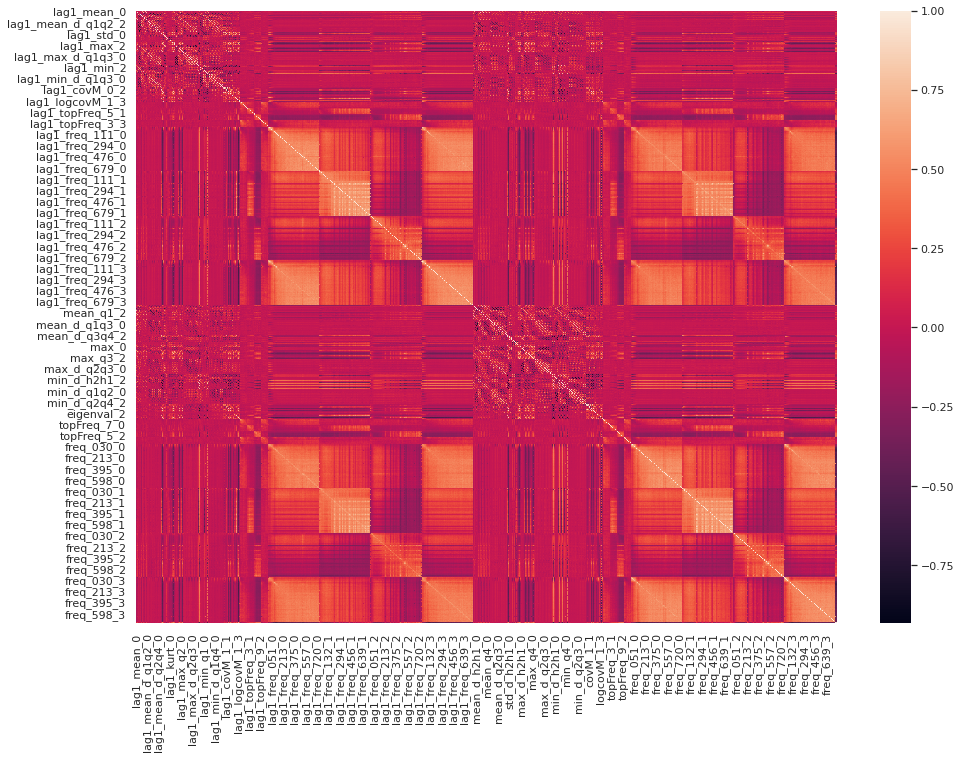

In [ ]:
sns.set(rc={'figure.figsize':(15.7,11.27)})
sns.heatmap(df_train.corr())

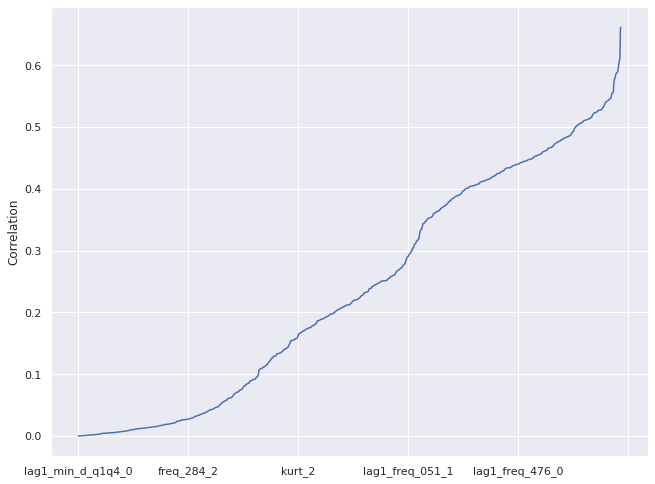

In [ ]:
features_correlation = select_k_best_correlated_features(df_train, 0.0, absolute=True, plot=True)

In [ ]:
values = features_correlation

In [ ]:
df_corr = features_correlation.to_frame()
df_corr.head()

,Label
lag1_mean_0,0.350962
lag1_mean_1,0.081398
lag1_mean_2,0.091466
lag1_mean_3,0.235254
lag1_mean_d_h2h1_0,0.006135


In [ ]:
def plot_dist(df, col, xlabel, ylabel, title, color = "cornflowerblue"):
  #https://stackoverflow.com/questions/22408237/named-colors-in-matplotlib
  sns.set_theme()
  sns.set_context("poster", font_scale=1.5)
  sns.set_palette("pastel")
  sns.set(rc={'figure.figsize':(8.7,6.27)})
  ax = sns.histplot(data=df, x=col, color=color)
  plt.xlabel(xlabel, fontdict = {'fontsize' : 21})
  plt.ylabel(ylabel, fontdict = {'fontsize' : 21})
  plt.title(title, fontdict = {'fontsize' : 24}, y=1.05)
  ax.tick_params(axis='both', which='major', labelsize=16)
  ax.tick_params(axis='both', which='minor', labelsize=16)

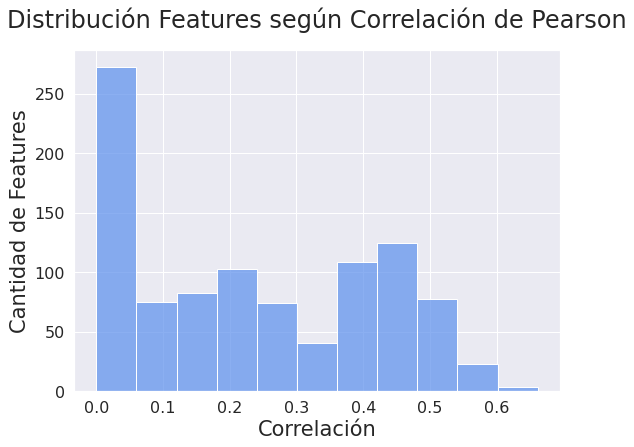

In [ ]:
plot_dist(df_corr, col = "Label", xlabel = "Correlación", ylabel="Cantidad de Features", title="Distribución Features según Correlación de Pearson")

In [ ]:
xs = [ _ for _ in range(len(values))]

Text(0.5, 1.0, '')

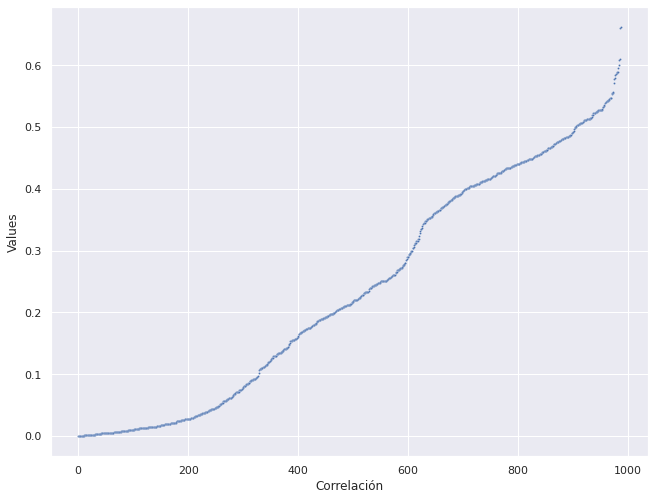

In [ ]:
ax = sns.scatterplot(x=xs, y=features_correlation.sort_values().values, s=4).set(title='Correlación Pearson')
plt.xlabel("Correlación")
plt.ylabel("Values")
plt.title("")

#### Plot correlación

In [ ]:
corr_abs_best = select_k_best_correlated_features(df_train, 0.5, absolute=True).index.to_list()

In [ ]:
#corr_abs_best.sort_values(ascending=False).head(20)
print('Cant.Features:',len(corr_abs_best))

Cant.Features: 84


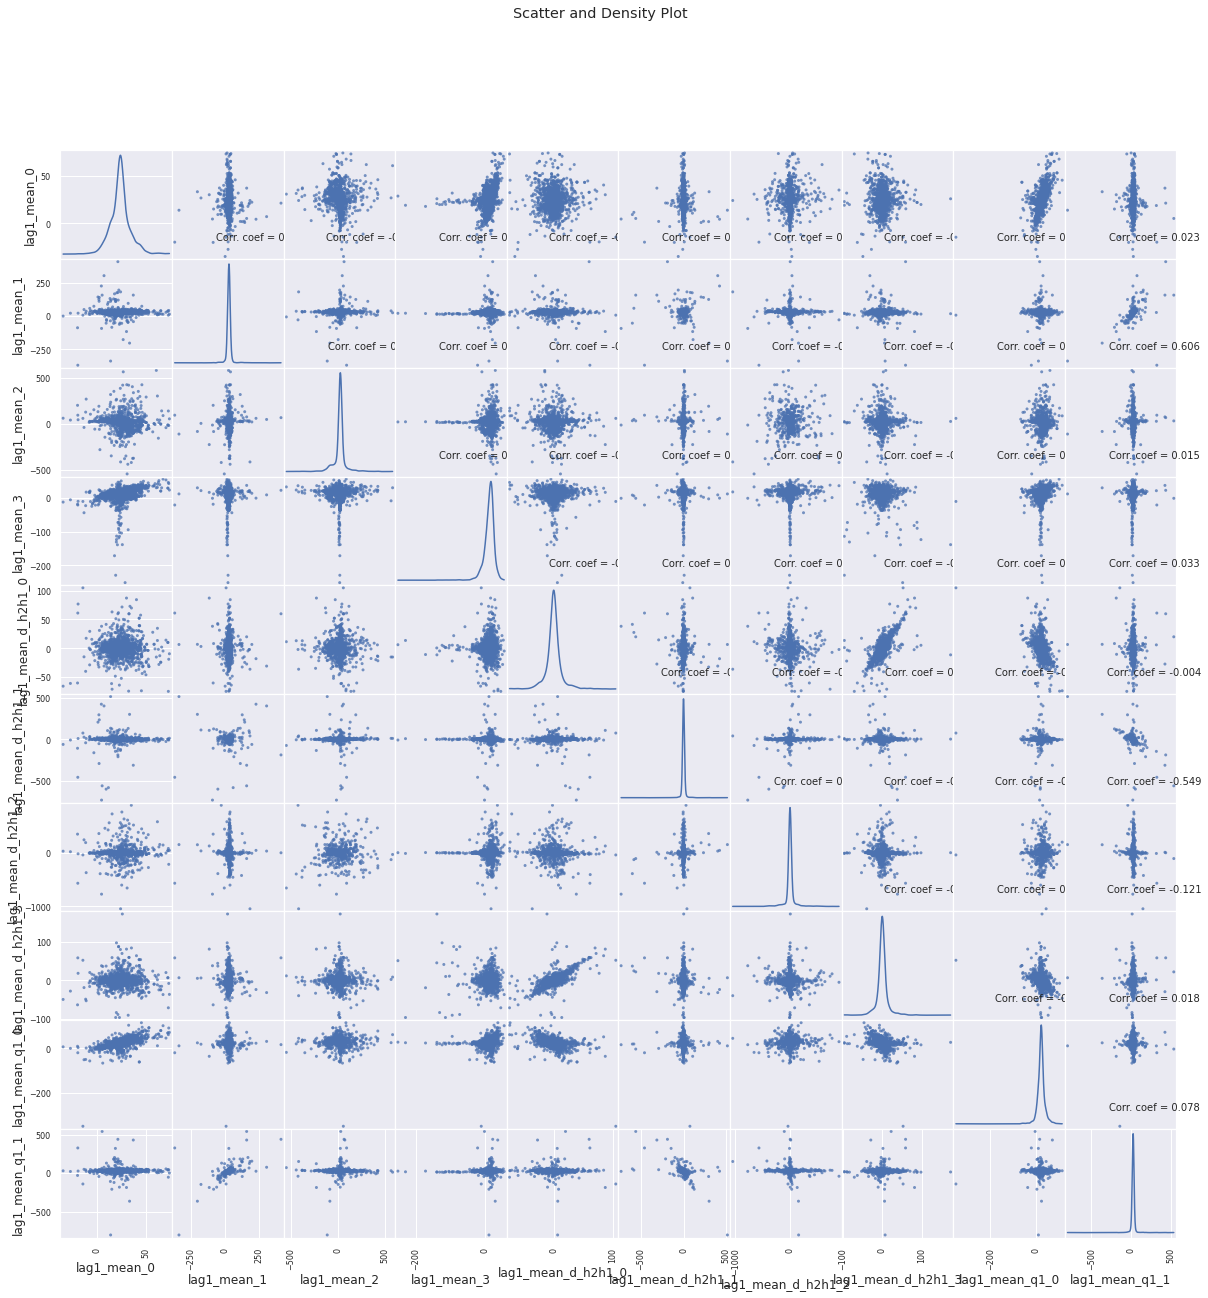

In [ ]:
plotScatterMatrix(df_train, 20, 10)

Exploración si alguna variable tienen mayor poder de predicción en una regresión logística para con el target categorico

In [ ]:

def experimento_feat_sel_log_reg(runs=1):
  random_seeds = [random.randint(1, 100) for _ in range(runs)]
  columns = X_train_set.columns

  scores = np.zeros((len(columns),2))

  for run_num, seed in enumerate(random_seeds):
    X_train, X_test, y_train, y_test = train_test_split(X_train_set, y_train_set, test_size=0.2, random_state=seed, stratify=y_train_set)

    for index, column in enumerate(columns):
      clf = LogisticRegression(random_state=seed).fit(X_train[[column]], y_train)
      scores[index, 0] += clf.score(X_train[[column]], y_train)
      scores[index, 1] += clf.score(X_test[[column]], y_test)

  scores/=runs
  column_fs_data = {'column': X_train.columns.to_list(), 'train_score': scores[:,0], 'test_score': scores[:,1]} 
  scores_each_column = pd.DataFrame(column_fs_data)

  return scores_each_column

def plot_exp_log_reg(df, head):
  sns.set(rc={'figure.figsize':(40,8)})

  fig, axes  = plt.subplots(2, 3)
  fig.suptitle('Training score por cada feature')

  for index, data in enumerate(['train_score', 'test_score']):
    ax1= sns.barplot(ax=axes[index][0], data=scores_each_column.sort_values(by=data, ascending=False).head(head), x='column', y=data)
    ax2= sns.barplot(ax=axes[index][1], data=scores_each_column.sort_values(by=data).head(head), x='column', y=data)
    x_arange = np.arange(0, len(scores_each_column))
    sns.scatterplot(ax=axes[index][2], data=scores_each_column.sort_values(by=data, ascending=0), x=x_arange, y=data)

    ax1.set_xticklabels(axes[index][0].get_xticklabels(), rotation=70)
    ax2.set_xticklabels(axes[index][1].get_xticklabels(), rotation=70)

#TODO unir los best y worst en un solo df y ploter eso

In [ ]:

def experimento_drop_feat_sel_log_reg(runs=1):
  random_seeds = [random.randint(1, 100) for _ in range(runs)]
  columns = X_train_set.columns

  scores = np.zeros((len(columns),2))

  for run_num, seed in enumerate(random_seeds):
    X_train, X_test, y_train, y_test = train_test_split(X_train_set, y_train_set, test_size=0.2, random_state=seed, stratify=y_train_set)
  
    for index, column in enumerate(columns):
      clf = LogisticRegression(random_state=seed, max_iter=200).fit(X_train.drop([column], axis=1), y_train)
      scores[index, 0] += clf.score(X_train.drop([column], axis=1), y_train)
      scores[index, 1] += clf.score(X_test.drop([column], axis=1), y_test)

  scores/=runs
  column_fs_data = {'column': X_train.columns.to_list(), 'train_score': scores[:,0], 'test_score': scores[:,1]} 
  scores_each_column = pd.DataFrame(column_fs_data)

  return scores_each_column

def plot_exp_log_reg(df, head):
  sns.set(rc={'figure.figsize':(40,8)})

  fig, axes  = plt.subplots(2, 3)
  fig.suptitle('Training score por cada feature')

  for index, data in enumerate(['train_score', 'test_score']):
    ax1= sns.barplot(ax=axes[index][0], data=scores_each_column.sort_values(by=data, ascending=False).head(head), x='column', y=data)
    ax2= sns.barplot(ax=axes[index][1], data=scores_each_column.sort_values(by=data).head(head), x='column', y=data)
    x_arange = np.arange(0, len(scores_each_column))
    sns.scatterplot(ax=axes[index][2], data=scores_each_column.sort_values(by=data, ascending=0), x=x_arange, y=data)

    ax1.set_xticklabels(axes[index][0].get_xticklabels(), rotation=70)
    ax2.set_xticklabels(axes[index][1].get_xticklabels(), rotation=70)

#TODO unir los best y worst en un solo df y ploter eso

In [ ]:
scores_each_column_drop = experimento_drop_feat_sel_log_reg(runs=10)

Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

In [ ]:
plot_dist(scores_each_column_drop, col = "train_score", xlabel = "Train Score", ylabel="Cantidad de Features", title="Distribución Features según Accuracy", color="mediumslateblue")

In [ ]:
scores_each_column = experimento_feat_sel_log_reg(runs=10)

In [ ]:
scores_each_column

,column,train_score,test_score
0,lag1_mean_0,0.496658,0.491688
1,lag1_mean_1,0.456999,0.468766
2,lag1_mean_2,0.387074,0.396725
3,lag1_mean_3,0.415511,0.408312
4,lag1_mean_d_h2h1_0,0.303279,0.296474
...,...,...,...
983,freq_709_3,0.479130,0.469270
984,freq_720_3,0.481148,0.464484
985,freq_730_3,0.484489,0.480605
986,freq_740_3,0.473203,0.471788


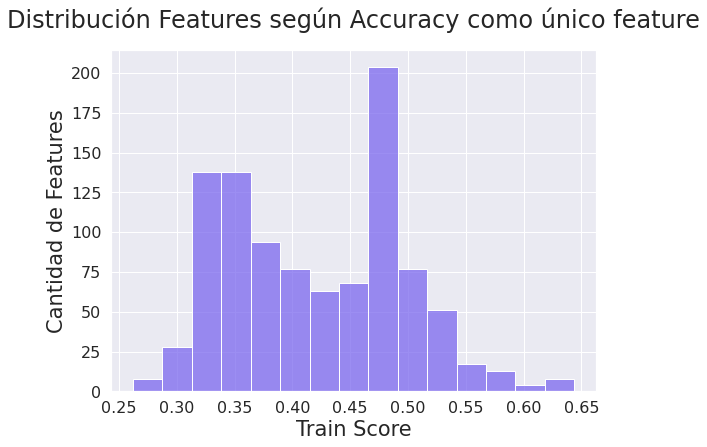

In [ ]:
plot_dist(scores_each_column, col = "train_score", xlabel = "Train Score", ylabel="Cantidad de Features", title="Distribución Features según Accuracy como único feature", color="mediumslateblue")

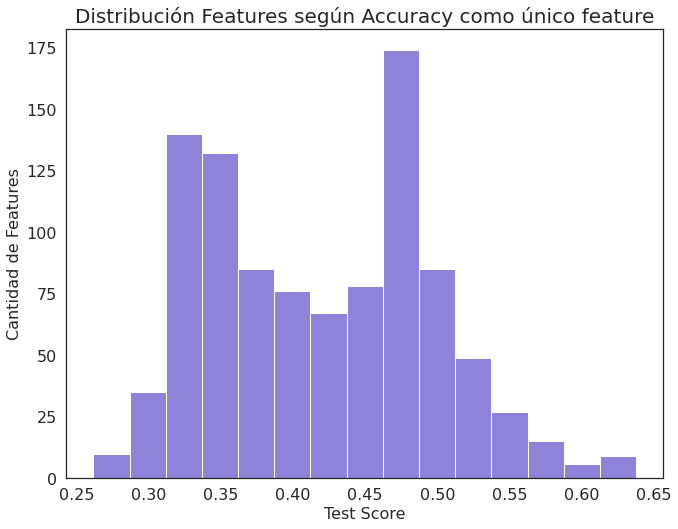

In [ ]:
#pensar poner las 2 distribuciones en un solo lugar
plot_dist(scores_each_column, col = "test_score", xlabel = "Test Score", ylabel="Cantidad de Features", title="Distribución Features según Accuracy como único feature", color="slateblue")

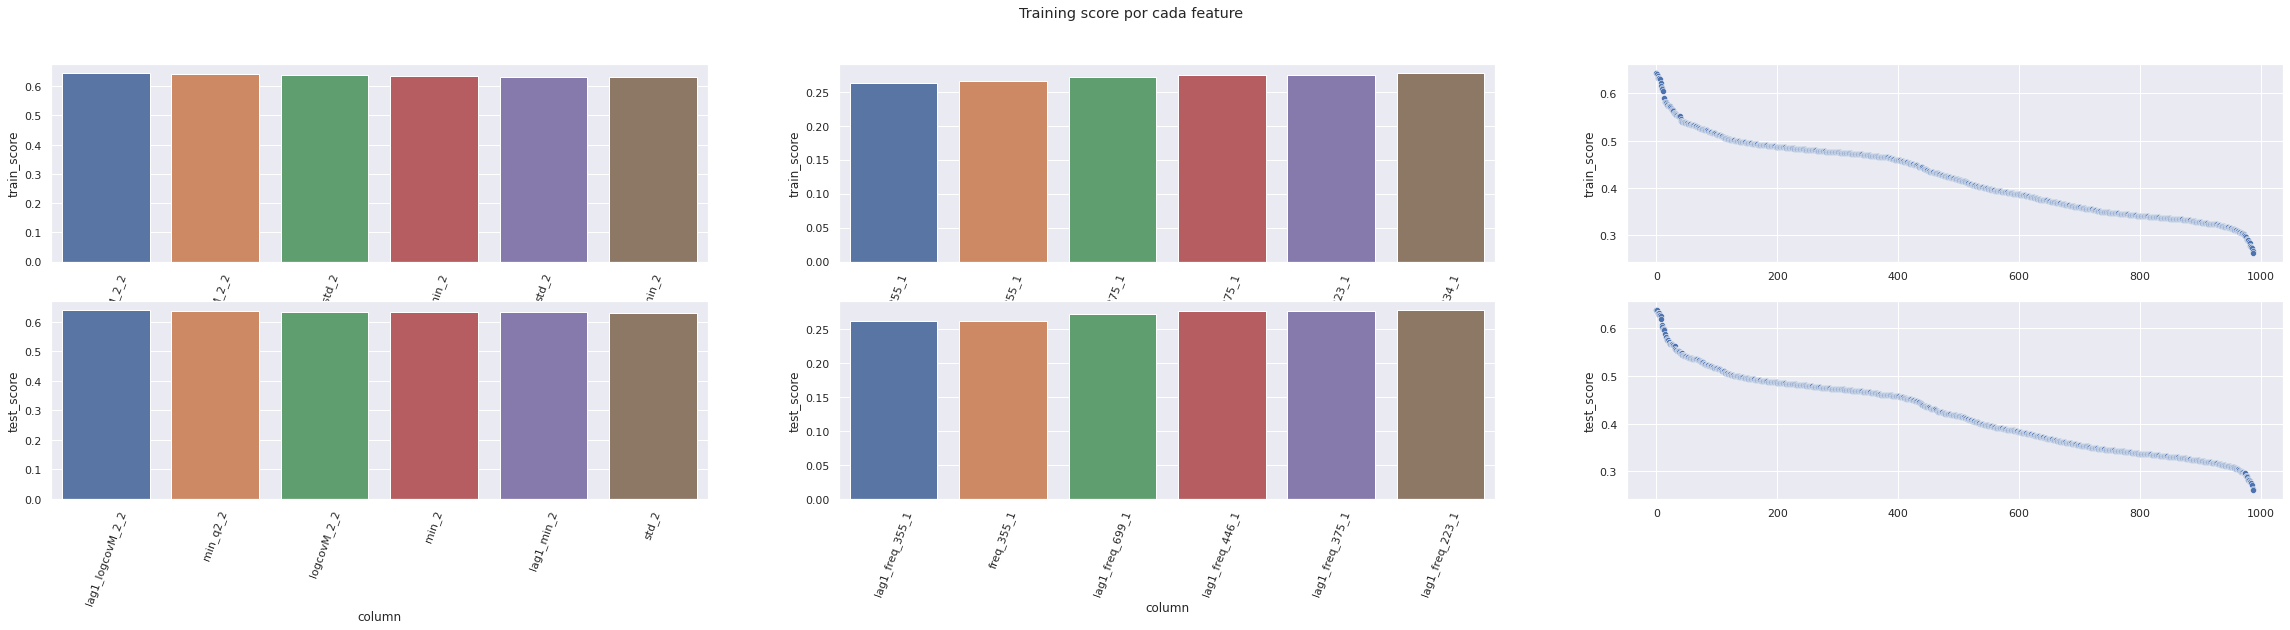

In [ ]:
plot_exp_log_reg(scores_each_column, 6)

In [ ]:
# Se hace corte para arriba de 0.6 +-
def select_best_log_reg(from_k, to_k, step):
  cortes_score_regres_log = np.arange(from_k, to_k, step)
  log_reg_best_predictores = [scores_each_column.sort_values(by='test_score', ascending=False).head(k)['column'].to_list() for k in cortes_score_regres_log] 
  return log_reg_best_predictores

Testing entre score best correlacion, best según regresión logística y con la intersección.

In [ ]:
def exp_score(cols_exp_list, runs=1):
  
  random_seeds = [random.randint(1, 100) for _ in range(runs)]

  scores = np.zeros((len(cols_exp_list),2))

  for run_num, seed in enumerate(random_seeds):
    X_train, X_test, y_train, y_test = train_test_split(X_train_set, y_train_set, test_size=0.2, random_state=seed, stratify=y_train_set)

    for index, column in enumerate(cols_exp_list):
      clf = LogisticRegression(random_state=seed, max_iter=400)
      pipe = Pipeline([('scaler', StandardScaler()), ('log', clf)])
      pipe.fit(X_train[column], y_train)
      scores[index, 0] += pipe.score(X_train[column], y_train)
      scores[index, 1] += pipe.score(X_test[column], y_test)

  scores/=runs
  lens = [len(x) for x in cols_exp_list]
  column_fs_data = {'cols_len': lens, 'train_score': scores[:,0], 'test_score': scores[:,1]} 
  scores_subset_column = pd.DataFrame(column_fs_data)

  return scores_subset_column
  
def plot_exp_log_reg(df):
  sns.set(rc={'figure.figsize':(20,8)})

  fig, axes = plt.subplots(1, 2)
  fig.suptitle('Training score por cada subset feature')

  for index, data in enumerate(['train_score', 'test_score']):
    sns.scatterplot(ax=axes[index], data=df, x='cols_len', y=data)

In [ ]:
print('#Col por correlacion: {}'.format(len(corr_abs_best)))
# print('#Col por acc en logist regres: {}'.format(len((log_reg_best))))
print('#Col por acc en logist regres: {}'.format(len((scores_each_column))))

#Col por correlacion: 84
#Col por acc en logist regres: 988


In [ ]:
logreg_corr_interseccion = [ list(set(log_reg_best_predictor).intersection(set(corr_abs_best))) for log_reg_best_predictor in log_reg_best_predictores]

In [ ]:
lens = [len(x) for x in logreg_corr_interseccion ]
lens

[19, 26, 32, 39, 46, 54, 62, 69, 76, 82, 83, 84, 84, 84, 84, 84, 84, 84]

In [ ]:
log_reg_best_predictores+=logreg_corr_interseccion

In [ ]:
log_reg_best_predictores = select_best_log_reg(20,200,10)

In [ ]:
log_reg_best_predictores

[['lag1_logcovM_2_2',
  'min_q2_2',
  'logcovM_2_2',
  'min_2',
  'lag1_min_2',
  'std_2',
  'min_q4_2',
  'lag1_std_2',
  'lag1_min_q2_2',
  'lag1_min_q1_2',
  'min_q1_2',
  'freq_122_3',
  'lag1_freq_111_0',
  'min_q3_2',
  'lag1_freq_122_3',
  'lag1_freq_111_3',
  'lag1_freq_122_0',
  'freq_091_0',
  'max_2',
  'freq_111_0'],
 ['lag1_logcovM_2_2',
  'min_q2_2',
  'logcovM_2_2',
  'min_2',
  'lag1_min_2',
  'std_2',
  'min_q4_2',
  'lag1_std_2',
  'lag1_min_q2_2',
  'lag1_min_q1_2',
  'min_q1_2',
  'freq_122_3',
  'lag1_freq_111_0',
  'min_q3_2',
  'lag1_freq_122_3',
  'lag1_freq_111_3',
  'lag1_freq_122_0',
  'freq_091_0',
  'max_2',
  'freq_111_0',
  'lag1_freq_101_3',
  'freq_111_3',
  'lag1_freq_101_0',
  'freq_122_0',
  'lag1_freq_517_0',
  'lag1_max_2',
  'freq_101_3',
  'freq_101_0',
  'max_q3_2',
  'freq_010_3'],
 ['lag1_logcovM_2_2',
  'min_q2_2',
  'logcovM_2_2',
  'min_2',
  'lag1_min_2',
  'std_2',
  'min_q4_2',
  'lag1_std_2',
  'lag1_min_q2_2',
  'lag1_min_q1_2',
  'min

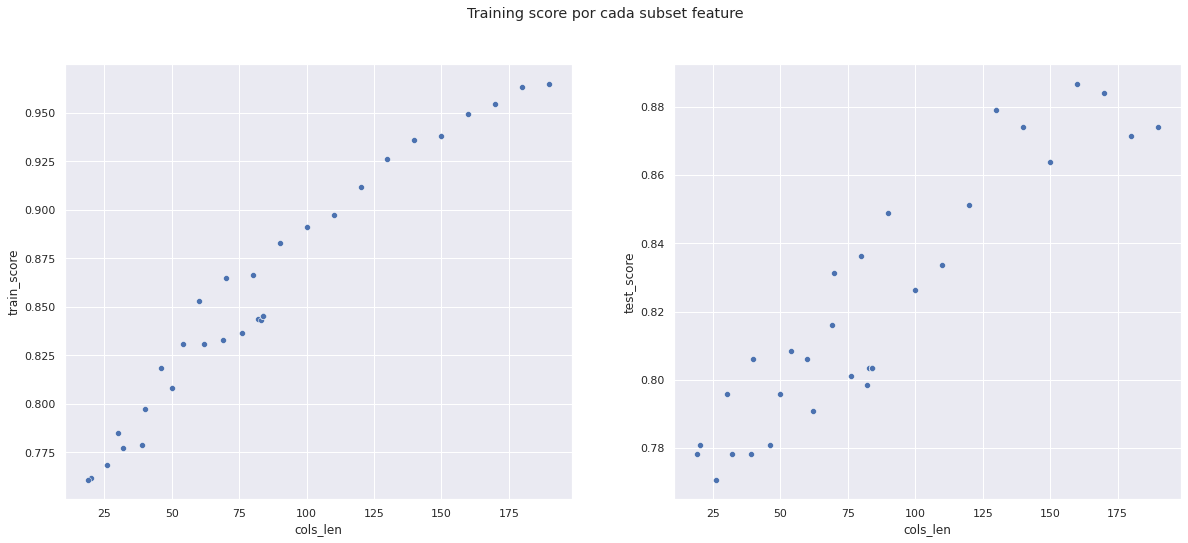

In [ ]:
exp_best_logreg = exp_score(log_reg_best_predictores)
plot_exp_log_reg(exp_best_logreg)

In [ ]:
large_exploration_log_reg_feautres = select_best_log_reg(50,800,50)

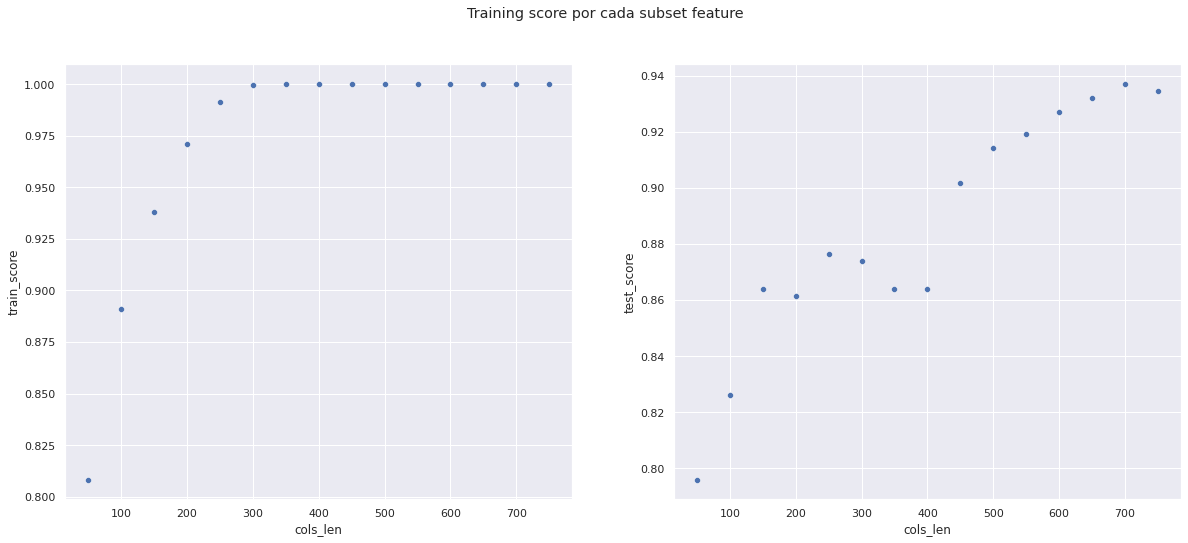

In [ ]:
exp_best_large_logreg = exp_score(large_exploration_log_reg_feautres)
plot_exp_log_reg(exp_best_large_logreg)
#TODO Probar con muchos random y ver cuándo converge

## 3. Filtrado de dataframe

Modelo Clasificación SVC

In [ ]:
# import some data to play with
def grafics(df1):
 X1 = df1.iloc[:,:6].values  # we only take the first two features. We could
                      # avoid this ugly slicing by using a two-dim dataset
 h = .02  # step size in the mesh

 # we create an instance of SVM and fit out data. We do not scale our
 # data since we want to plot the support vectors
 C = 1.0  # SVM regularization parameter
 svc = SVC(kernel='linear', C=C).fit(X1, y)
 rbf_svc = SVC(kernel='rbf', gamma=0.7, C=C).fit(X1, y)
 poly_svc = SVC(kernel='poly', degree=3, C=C).fit(X1, y)

 # create a mesh to plot in
 x_min, x_max = X1[:, 0].min() - 1, X1[:, 0].max() + 1
 y_min, y_max = X1[:, 1].min() - 1, X1[:, 1].max() + 1
 xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

 # title for the plots
 titles = ['SVC with linear kernel',
          'SVC with RBF kernel',
          'SVC with polynomial (degree 3) kernel']


 for i, clf in enumerate((svc, lin_svc, rbf_svc, poly_svc)):
    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    plt.subplot(2, 2, i + 1)
    plt.subplots_adjust(wspace=0.4, hspace=0.4)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)

    # Plot also the training points
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm)
    plt.xlabel('Sepal length')
    plt.ylabel('Sepal width')
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.xticks(())
    plt.yticks(())
    plt.title(titles[i])
plt.show()
@njit(fastmath=True, cache=True)

SyntaxError: ignored

In [ ]:
# Función que devuelve Score en SVC Lineal y SVC Gamma
def Support_Vector_Classifier (X, y, c1, c2):
  clfSVCL = SVC(kernel="linear", C=c1, probability=True)
  clfSVCL.fit(X, y) # entreno
  score_svcl = clfSVCL.score(X_test, y_test) # evaluo
 
  clfSVCG = SVC(gamma=2, C=c2, probability=True)
  clfSVCG.fit(X_train, y_train) # entreno
  score_svcg = clfSVCG.score(X_test, y_test) # evaluo
  print('score SVC Lineal:', score_svcl,', score SVC Gama:', score_svcg)

In [ ]:
X = df_train[corr_abs_best]
print(X.count)
y = df_train['Label']


<bound method DataFrame.count of       lag1_std_2  lag1_min_2  lag1_min_q1_2  ...  freq_223_3  freq_233_3  freq_243_3
599    13.162199   -9.605437      -9.605437  ...    0.006758    0.030156    0.006876
1532    3.752438   19.309194      22.176754  ...    0.018081    0.019788    0.030332
2307    4.552069   13.377322      14.660506  ...    0.017957    0.028487    0.023364
1377    9.385856    6.088007       8.034710  ...    0.005623    0.009624    0.010408
629    13.405969   -6.568507      -6.568507  ...    0.004416    0.006888    0.017152
...          ...         ...            ...  ...         ...         ...         ...
1730   11.951695   -0.093576       5.339470  ...    0.045853    0.047358    0.028835
1557    3.602031   13.714453      17.175639  ...    0.016609    0.030620    0.053539
363    10.436581   -0.999698       6.426272  ...    0.008745    0.040627    0.021773
2332    8.841272   -3.036802       4.799744  ...    0.031887    0.010179    0.005442
865     4.771423   16.451830    

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)
print(X_train.shape, y_train.shape)

(1586, 84) (1586,)


In [ ]:
# CLASIFICACIÓN: SVC,  SELECTION FEATURE: CORRELATION PEARSON
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)
Support_Vector_Classifier(X_train, y_train, 0.025, 1 )

score SVC Lineal: 0.6826196473551638 , score SVC Gama: 0.3501259445843829


In [ ]:
df_train = pd.concat([X, y], axis=1)
print(df_train.shape, y.shape)


(1983, 85) (1983,)


In [ ]:
 #Selección de Features con PCA utilizando como imput la selección de Correlación Pearson
 pca = PCA(n_components=6)
 X_train = pca.fit_transform(df_train)
 X_test = pca.fit_transform(X_test)
 print('Dimensiones de la matriz en componentes principales: {}'.format(X_train.shape))

Dimensiones de la matriz en componentes principales: (1983, 6)


In [ ]:
# Hacemos un scatter de los datos en las dos primeras componentes
fig, ax = plt.subplots(figsize = (10, 6))
ax.scatter(X_train[:,0], X_train[:,1], alpha = 0.45 ) 

ax.set_xlabel('Primer componente principal')
ax.set_ylabel('Segunda componente principal')

Text(0.5, 0, 'Cantidad de componentes principales')

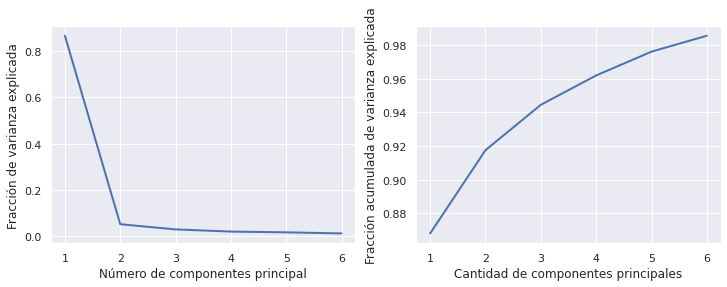

In [ ]:
# con .explained_variance_ratio_ vemos la fracción de información que aporta cada componente
evr = pca.explained_variance_ratio_

# Graficamos la fracción de varianza que aporta cada componente
# y la información acumulada
fig, ax = plt.subplots(1, 2, figsize = (12, 4))

ax[0].plot(range(1, len(evr) + 1), evr, '-', linewidth = 2)
ax[0].set_ylabel('Fracción de varianza explicada')
ax[0].set_xlabel('Número de componentes principal')

# Calculamos el acumulado con la función cumsum de numpy 
varianza_acumulada = np.cumsum(evr)
# graficamos la fracción de varianza explicada y la varianza acumulada
ax[1].plot(range(1, len(evr) + 1), varianza_acumulada, '-', linewidth = 2)
ax[1].set_ylabel('Fracción acumulada de varianza explicada')
ax[1].set_xlabel('Cantidad de componentes principales')

In [ ]:
# CLASIFICACIÓN: SVC,  SELECTION FEATURE: PCA a partir de Corr Pearson
print(len(X_train), len(y))
clfSVCL1 = SVC(kernel="linear", C=0.025, probability=True)
clfSVCL1.fit(X_train, y) # entreno
score_svcl = clfSVCL1.score(X_test, y_test) # evaluo
 
clfSVCG1 = SVC(gamma=2, C=0.025, probability=True)
clfSVCG1.fit(X_train, y) # entreno
score_svcg = clfSVCG1.score(X_test, y_test) # evaluo
print('score SVC Lineal:', score_svcl,', score SVC Gama:', score_svcg)


In [ ]:
# QUIERO GRAFICAR ESTE SVC !!!!! y se llena la RAM CHANN!!!
X1 = X_train  # we only take the first two features. We could
                      # avoid this ugly slicing by using a two-dim dataset
h = .02  # step size in the mesh

 # we create an instance of SVM and fit out data. We do not scale our
 # data since we want to plot the support vectors
C = 1.0  # SVM regularization parameter
svc = SVC(kernel='linear', C=C).fit(X1, y)
rbf_svc = SVC(kernel='rbf', gamma=0.7, C=C).fit(X1, y)
poly_svc = SVC(kernel='poly', degree=3, C=C).fit(X1, y)

 # create a mesh to plot in
x_min, x_max = X1[:, 0].min() - 1, X1[:, 0].max() + 1
y_min, y_max = X1[:, 1].min() - 1, X1[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

 # title for the plots
titles = ['SVC with linear kernel',
          'SVC with RBF kernel',
          'SVC with polynomial (degree 3) kernel']


for i, clf in enumerate((svc, lin_svc, rbf_svc, poly_svc)):
    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    plt.subplot(2, 2, i + 1)
    plt.subplots_adjust(wspace=0.4, hspace=0.4)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)

    # Plot also the training points
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm)
    plt.xlabel('Sepal length')
    plt.ylabel('Sepal width')
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.xticks(())
    plt.yticks(())
    plt.title(titles[i])

plt.show()

NameError: ignored

In [ ]:
#compruebo si hay diferencias
X_train.shape[0] != y.shape[0]

NameError: ignored

In [ ]:
X = df_train[corr_abs_best].values
grafics()


NameError: ignored

Modelo Clasificación: KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

def experimentacion_feature_selection(df_train, correlaciones_a_testeear):
  scores_test = []
  # otro vector con otra metrica 
  X = df_train.iloc[:, :-1]
  print(X.shape)
  y = df_train['Label']
  neigh = KNeighborsClassifier(n_neighbors=3)
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)
  # cross validation
  for correlacion_corte in correlaciones_a_testeear:
    print(correlacion_corte)
    columns = select_k_best_correlated_features(df_train, correlacion_corte, absolute=True)
    columns = columns.index.to_list()
    X_train_fit = X_train[columns]
    X_test_fit = X_test[columns]
    neigh.fit(X_train_fit, y_train)
    scores_test.append(neigh.score(X_test_fit, y_test))
    # agregar valor de otra metrica
  return scores_test #,  

In [ ]:
corr_cut_exp = np.arange(start=0.1, step=0.1, stop=0.5)
experimentacion_feature_selection(df_train, corr_cut_exp)

(1983, 988)
0.1
0.2
0.30000000000000004
0.4


[0.8967254408060453, 0.836272040302267, 0.7909319899244333, 0.7732997481108312]

In [ ]:
defskf = StratifiedKFold(n_splits=5, shuffle=True) # 5 folds es un número típico si tenemos suficientes datos. Pedimos shuffle=True para que sea al azar la separación en subgrupos
defskf.get_n_splits(X, y_shuffled) # arma los folds a partir de los datos

auc_values = [] # aca es donde van a ir a parar los AUCs de cada fold
scores_shuffled = np.array([])     # aca es donde van a ir a parar los scores computados para todos los casos
indices_shuffled = np.array([])    # aca es donde van a ir a parar los indices correspondientes a las entradas de scores
targets_shuffled = np.array([])    # aca es donde van a ir a parar los targets en el orden de la validacion cruzada

for train_index, test_index in skf.split(X, y_shuffled): # va generando los indices que corresponden a train y test en cada fold
    X_train, X_test = X[train_index], X[test_index] # arma que es dato de entrenamiento y qué es dato de evaluación
    y_train, y_test = y_shuffled[train_index], y_shuffled[test_index]     # idem con los targets

    regLog_1 = LogisticRegression(penalty = 'none', max_iter=10000) # Inicializamos nuevamente el modelo. max_iter es la cantidad de iteraciones maximas del algoritmo de optimizacion de parametros antes de detenerse.
    regLog_1.fit(X_train, y_train) # Ajustamos el modelo con los datos de entrenamiento

    probas_test = regLog_1.predict_proba(X_test)  # probabilidades con datos de evaluación
    fpr_test, tpr_test, thresholds_test = roc_curve(y_test, probas_test[:,1]) # para plotear curva ROC con datos de entrenamiento
    auc_test = roc_auc_score(y_test, probas_test[:,1]) #  AUC con datos de evaluación

    auc_values.append(auc_test)
    scores_shuffled  = np.concatenate((scores_shuffled ,probas_test[:,1]),axis=0)
    indices_shuffled  = np.concatenate((indices_shuffled ,test_index),axis=0)
    targets_shuffled  = np.concatenate((targets_shuffled ,y_test),axis=0)

In [ ]:
corr_cut_exp

array([0.1, 0.2, 0.3, 0.4])

In [ ]:
X = df_train.iloc[:, :-1]

In [ ]:
X

,lag1_mean_0,lag1_mean_1,lag1_mean_2,lag1_mean_3,lag1_mean_d_h2h1_0,lag1_mean_d_h2h1_1,lag1_mean_d_h2h1_2,lag1_mean_d_h2h1_3,lag1_mean_q1_0,lag1_mean_q1_1,lag1_mean_q1_2,lag1_mean_q1_3,lag1_mean_q2_0,lag1_mean_q2_1,lag1_mean_q2_2,lag1_mean_q2_3,lag1_mean_d_q1q2_0,lag1_mean_d_q1q2_1,lag1_mean_d_q1q2_2,lag1_mean_d_q1q2_3,lag1_mean_d_q1q3_0,lag1_mean_d_q1q3_1,lag1_mean_d_q1q3_2,lag1_mean_d_q1q3_3,lag1_mean_d_q1q4_0,lag1_mean_d_q1q4_1,lag1_mean_d_q1q4_2,lag1_mean_d_q1q4_3,lag1_mean_d_q2q3_0,lag1_mean_d_q2q3_1,lag1_mean_d_q2q3_2,lag1_mean_d_q2q3_3,lag1_mean_d_q2q4_0,lag1_mean_d_q2q4_1,lag1_mean_d_q2q4_2,lag1_mean_d_q2q4_3,lag1_std_0,lag1_std_1,lag1_std_2,lag1_std_3,...,freq_334_3,freq_345_3,freq_355_3,freq_365_3,freq_375_3,freq_385_3,freq_395_3,freq_405_3,freq_416_3,freq_426_3,freq_436_3,freq_446_3,freq_456_3,freq_466_3,freq_476_3,freq_486_3,freq_517_3,freq_527_3,freq_537_3,freq_547_3,freq_557_3,freq_568_3,freq_578_3,freq_588_3,freq_598_3,freq_608_3,freq_618_3,freq_628_3,freq_639_3,freq_649_3,freq_659_3,freq_669_3,freq_679_3,freq_689_3,freq_699_3,freq_709_3,freq_720_3,freq_730_3,freq_740_3,freq_750_3
599,11.537566,16.870496,25.672934,10.074609,0.370285,3.153991,8.643819,-1.267567,13.882043,18.707515,20.071501,12.189058,8.889374,11.969329,22.596875,9.266692,4.992668,6.738186,-2.525374,2.922366,4.545913,-1.452252,-14.952259,5.081939,-0.164441,1.927240,-5.026765,0.475938,-0.446756,-8.190438,-12.426885,2.159573,-5.157109,-4.810946,-2.501390,-2.446428,13.857397,7.009853,13.162199,10.350476,...,0.008343,0.007182,0.014857,0.014529,0.017742,0.029518,0.018410,0.042312,0.036018,0.018843,0.022304,0.005723,0.012018,0.013869,0.019236,0.033209,0.008658,0.001754,0.050342,0.034018,0.021147,0.006093,0.008915,0.005151,0.014237,0.024742,0.019494,0.016017,0.009389,0.012979,0.008941,0.009964,0.018416,0.004521,0.004484,0.021764,0.012157,0.010525,0.004623,0.010069
1532,7.318473,32.680520,27.034789,10.841375,1.737171,-4.740527,-3.214662,1.170612,4.856279,32.910301,29.095461,9.484254,8.001559,37.134937,28.200709,11.007574,-3.145280,-4.224635,0.894751,-1.523320,-3.284599,2.268626,4.701692,-2.347138,-3.375744,2.922743,2.661515,-1.548366,-0.139319,6.493261,3.806941,-0.823818,-0.230464,7.147379,1.766763,-0.025047,6.530856,4.416139,3.752438,6.178357,...,0.018311,0.010236,0.017217,0.018192,0.028388,0.023612,0.032350,0.016758,0.004471,0.019379,0.012587,0.013670,0.011208,0.021646,0.017057,0.019006,0.024076,0.009637,0.016237,0.014478,0.019787,0.004012,0.016235,0.003770,0.016442,0.002954,0.012084,0.016812,0.001183,0.008839,0.005977,0.004414,0.012328,0.010778,0.011387,0.009560,0.005964,0.006867,0.018727,0.010924
2307,24.988191,18.928543,24.169957,8.136738,1.610951,-0.323726,0.782709,0.419431,27.204138,16.104362,22.915100,9.784324,21.240805,21.997870,24.619382,6.118597,5.963334,-5.893507,-1.704282,3.665727,2.880888,0.676721,0.322841,3.860401,-0.021250,-5.913487,-3.563446,-0.920910,-3.082446,6.570228,2.027123,0.194674,-5.984584,-0.019980,-1.859165,-4.586637,10.366199,5.120290,4.552069,8.300123,...,0.051233,0.008075,0.041823,0.043263,0.020244,0.014920,0.025024,0.024070,0.041690,0.015575,0.033465,0.021052,0.011330,0.013240,0.014005,0.018987,0.011335,0.007946,0.022013,0.021014,0.022946,0.015773,0.008784,0.014135,0.021615,0.029913,0.020428,0.015998,0.004415,0.017658,0.014659,0.024176,0.035494,0.004294,0.015143,0.002578,0.037975,0.022404,0.018985,0.007281
1377,17.866137,20.019543,30.679723,12.689574,-1.507275,8.348476,-0.025243,-1.803082,23.460320,0.128398,25.278887,17.362406,13.906611,31.148610,35.963343,9.919069,9.553709,-31.020212,-10.684456,7.443337,4.845275,-24.456355,-8.123962,4.139190,7.810825,-23.684701,-2.724460,6.971787,-4.708433,6.563857,2.560494,-3.304147,-1.742884,7.335512,7.959996,-0.471549,9.215361,35.585497,9.385856,9.102408,...,0.018626,0.004772,0.008809,0.005987,0.006612,0.006475,0.007315,0.008899,0.010624,0.005207,0.008407,0.010365,0.023074,0.010704,0.007800,0.005614,0.022523,0.008173,0.002115,0.014950,0.005816,0.004887,0.008620,0.015915,0.001501,0.006011

In [ ]:
len(df_train.columns)

989

Modelo Regresión: Random Forest

In [ ]:
# Creamos el clasificador con un máximo de 5 hojas
dtc = DecisionTreeClassifier(max_leaf_nodes = 5)

In [ ]:
# Entrenamiento del modelo
dtc.fit(X_train, y_train)

# Score del modelo en el conjunto de entrenamiento 
score_in_train = dtc.score(X_train, y_train)

# Score del modelo en el conjunto de testeo
score_in_test = dtc.score(X_test, y_test)

print('Score en el set de entrenamiento: {}'.format(score_in_train))
print('Score en el set de testeo: {}'.format(score_in_test))

Score en el set de entrenamiento: 0.7213114754098361
Score en el set de testeo: 0.7052896725440806


[Text(502.20000000000005, 391.392, 'std_2 <= 60.085\ngini = 0.667\nsamples = 1586\nvalue = [539, 523, 524]'),
 Text(334.8, 304.416, 'lag1_std_2 <= 7.744\ngini = 0.595\nsamples = 1155\nvalue = [537, 484, 134]'),
 Text(167.4, 217.44, 'gini = 0.189\nsamples = 224\nvalue = [201, 8, 15]'),
 Text(502.20000000000005, 217.44, 'freq_111_3 <= 0.058\ngini = 0.592\nsamples = 931\nvalue = [336, 476, 119]'),
 Text(334.8, 130.464, 'lag1_freq_649_2 <= 0.015\ngini = 0.576\nsamples = 688\nvalue = [178, 395, 115]'),
 Text(167.4, 43.488, 'gini = 0.651\nsamples = 399\nvalue = [114, 174, 111]'),
 Text(502.20000000000005, 43.488, 'gini = 0.366\nsamples = 289\nvalue = [64, 221, 4]'),
 Text(669.6, 130.464, 'gini = 0.466\nsamples = 243\nvalue = [158, 81, 4]'),
 Text(669.6, 304.416, 'gini = 0.173\nsamples = 431\nvalue = [2, 39, 390]')]

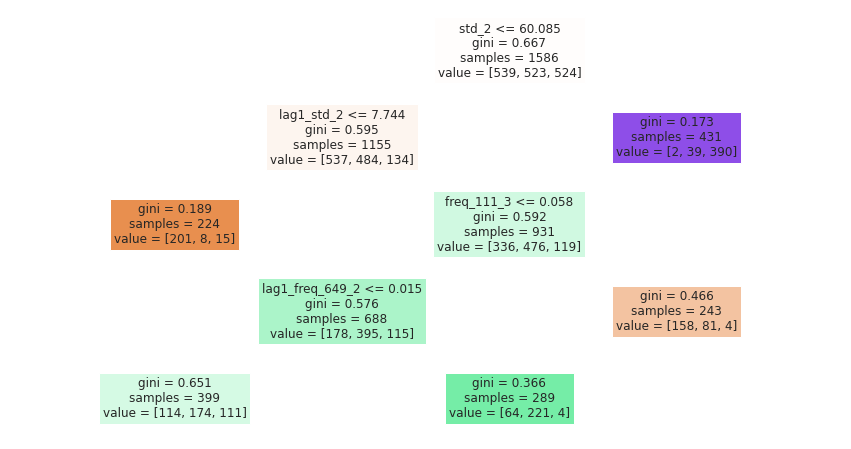

In [ ]:
# Creamos la figura donde plotear el árbol con matplotlib
fig, ax = plt.subplots(figsize = (15, 8))

# Llamamos a la función "plot_tree" que importamos de sklearn.tree más arriba.
# Le pasamos como argumento el modelo que creamos y el nombre de los features.
# "fontsize" y "filled" son solo ajustes de la visualización 
# y le decimos que plotee el arbol en la figura que creamos
plot_tree(dtc, feature_names=corr_abs_best, fontsize = 12, filled = True, ax = ax)

PCA

In [ ]:
filename = '/content/drive/MyDrive/Laboratorio de datos final/mental_study_EEG_dataset.csv'

In [ ]:
df = pd.read_csv(filename)
print("Cantidad de samples: {}\nCantidad de features: {}".format(df.shape[0], df.shape[1]))
df.head()

In [ ]:
def select_nodo_exp(df, nodo):
  col_freq = [col for col in df if col.startswith('freq_') and col.endswith(str(nodo))]
  return df[col_freq]

In [ ]:
select_nodo_exp(df, 0)

In [ ]:
# Con esta forma quitamos el ultimo feature 'Label'
X_train_set, X_test, y_train_set, y_test = train_test_split(df.iloc[:,:-1], df.iloc[:,-1], test_size=0.2, random_state=RANDOM_SEED, stratify=df.iloc[:,-1])
print(X_train_set.shape, X_test.shape)

In [ ]:
# Dataset de entranamiento completo
df_train = pd.concat([X_train_set, y_train_set], axis=1)
df_train.columns

In [ ]:
'''
  Select feature whose correlation with target is greater than cut.
  Absolute: True to consider asbolute values. Default: False
  Plot: to show a veryn simple plot
  Return: Highest K best correlated features and their values as  a Series
'''
def select_k_best_correlated_features(df, cut, corr_method='pearson', absolute=False, plot=False):
  sns.set(rc={'figure.figsize':(10.7,8.27)})
  corr = df.corr(method=corr_method)['Label']  #Si dejamos el Label funcionará
  corr = corr.drop(corr.index[-1])
  if absolute: corr = abs(corr)
  selected_features = corr[corr > cut]
  if plot: corr.sort_values().plot(ylabel='Correlation')
  return selected_features

In [ ]:
# Scatter and density plots
def plotScatterMatrix(df, plotSize, textSize):
    df = df.select_dtypes(include =[np.number]) # keep only numerical columns
    # Remove rows and columns that would lead to df being singular
    df = df.dropna('columns')
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    columnNames = list(df)
    if len(columnNames) > 10: # reduce the number of columns for matrix inversion of kernel density plots
        columnNames = columnNames[:10]
    df = df[columnNames]
    ax = pd.plotting.scatter_matrix(df, alpha=0.75, figsize=[plotSize, plotSize], diagonal='kde')
    corrs = df.corr().values
    for i, j in zip(*plt.np.triu_indices_from(ax, k = 1)):
        ax[i, j].annotate('Corr. coef = %.3f' % corrs[i, j], (0.8, 0.2), xycoords='axes fraction', ha='center', va='center', size=textSize)
    plt.suptitle('Scatter and Density Plot')
    plt.show()

print('Dimensiones de la matriz de features: {}'.format(X.shape))

NameError: ignored

In [ ]:
# Clase para realizar componentes principales
from sklearn.decomposition import PCA

# Estandarizador (transforma las variables en z-scores)
from sklearn.preprocessing import StandardScaler
std_scale = StandardScaler() # Creamos el estandarizador para usarlo posteriormente

In [ ]:
# Ajustamos el estandarizador
std_scale.fit(X)

# Aplicamos el estandarizador y obtenemos la matriz de features escaleados
X_scaled = std_scale.transform(X)

In [ ]:
# Creación del modelo de PCA con todas las componentes
pca = PCA(n_components = None)


In [ ]:
# Ajustamos el modelo a los datos escaleados
pca.fit(X_scaled)

# Obtenemos la descripción de los datos en el espacio de componentes principales
X_pca = pca.transform(X_scaled)

print('Dimensiones de la matriz en componentes principales: {}'.format(X_pca.shape))
print(X_pca)

In [ ]:
# con .explained_variance_ratio_ vemos la fracción de información que aporta cada componente
evr = pca.explained_variance_ratio_

# Graficamos la fracción de varianza que aporta cada componente
# y la información acumulada
fig, ax = plt.subplots(1, 2, figsize = (12, 4))

ax[0].plot(range(1, len(evr) + 1), evr, '.-', markersize = 20)
ax[0].set_ylabel('Fracción de varianza explicada')
ax[0].set_xlabel('Número de componente principal')

# Calculamos el acumulado con la función cumsum de numpy 
varianza_acumulada = np.cumsum(evr)

ax[1].plot(range(1, len(evr) + 1), varianza_acumulada, '.-', markersize = 20)
ax[1].set_ylabel('Fracción acumulada de varianza explicada')
ax[1].set_xlabel('Cantidad de componentes principales')

El gráfico de la izquierda nos dice qué fracción de información aporta cada componente. Lo que es importante notar es que cada componente aporta menos información que la anterior, por lo que las mismas están ordenadas de más a menos informativas.

Quizás el gráfico de la derecha es más interesante: lo que nos dice es que tomando solamente las 150 primeras componentes cubrimos el 75% aproximadamente de la información, con 200, aproximadamente el 80%, y así. Cuando tomamos tantas componentes como features en nuestro dataset original, no hay pérdida de información (esto simplemente se corresponde a un cambio de base del espacio de features al espacio de componentes principales).

In [ ]:
print('Features = {}'.format(features))
print('PCA1 = {}'.format(pca.components_[0]))
print('PCA2 = {}'.format(pca.components_[1]))
print('PCA3 = {}'.format(pca.components_[2]))
print('PCA4 = {}'.format(pca.components_[3]))
print('PCA5 = {}'.format(pca.components_[4]))
print('PCA6 = {}'.format(pca.components_[5]))
print('PCA7 = {}'.format(pca.components_[6]))
print('PCA8 = {}'.format(pca.components_[7]))
print('PCA9 = {}'.format(pca.components_[8]))
print('PCA10 = {}'.format(pca.components_[9]))
print('PCA11 = {}'.format(pca.components_[10]))
print('PCA12 = {}'.format(pca.components_[11]))
print('PCA13 = {}'.format(pca.components_[12]))
print('PCA14 = {}'.format(pca.components_[13]))
print('PCA15 = {}'.format(pca.components_[14]))
print('PCA16 = {}'.format(pca.components_[15]))
print('PCA17 = {}'.format(pca.components_[16]))
print('PCA18 = {}'.format(pca.components_[17]))
print('PCA19 = {}'.format(pca.components_[18]))
print('PCA20 = {}'.format(pca.components_[19]))
print('PCA21 = {}'.format(pca.components_[20]))
print('PCA22 = {}'.format(pca.components_[21]))
print('PCA23 = {}'.format(pca.components_[22]))
print('PCA24 = {}'.format(pca.components_[23]))
print('PCA25 = {}'.format(pca.components_[24]))
print('PCA26 = {}'.format(pca.components_[25]))
print('PCA27 = {}'.format(pca.components_[26]))
print('PCA28 = {}'.format(pca.components_[27]))
print('PCA29 = {}'.format(pca.components_[28]))
print('PCA30 = {}'.format(pca.components_[29]))
print('PCA31 = {}'.format(pca.components_[30]))
print('PCA32 = {}'.format(pca.components_[31]))
print('PCA33 = {}'.format(pca.components_[32]))
print('PCA34 = {}'.format(pca.components_[33]))
print('PCA35 = {}'.format(pca.components_[34]))
print('PCA36 = {}'.format(pca.components_[35]))
print('PCA37 = {}'.format(pca.components_[36]))
print('PCA38 = {}'.format(pca.components_[37]))
print('PCA39 = {}'.format(pca.components_[38]))
print('PCA40 = {}'.format(pca.components_[39]))
print('PCA41 = {}'.format(pca.components_[40]))
print('PCA42 = {}'.format(pca.components_[41]))
print('PCA43 = {}'.format(pca.components_[42]))
print('PCA44 = {}'.format(pca.components_[43]))
print('PCA45 = {}'.format(pca.components_[44]))
print('PCA46 = {}'.format(pca.components_[45]))
print('PCA47 = {}'.format(pca.components_[46]))
print('PCA48 = {}'.format(pca.components_[47]))
print('PCA49 = {}'.format(pca.components_[48]))
print('PCA50 = {}'.format(pca.components_[49]))
print('PCA51 = {}'.format(pca.components_[50]))
print('PCA52 = {}'.format(pca.components_[51]))
print('PCA53 = {}'.format(pca.components_[52]))
print('PCA54 = {}'.format(pca.components_[53]))
print('PCA55 = {}'.format(pca.components_[54]))
print('PCA56 = {}'.format(pca.components_[55]))
print('PCA57 = {}'.format(pca.components_[56]))
print('PCA58 = {}'.format(pca.components_[57]))
print('PCA59 = {}'.format(pca.components_[58]))
print('PCA60 = {}'.format(pca.components_[59]))
print('PCA61 = {}'.format(pca.components_[60]))
print('PCA62 = {}'.format(pca.components_[61]))
print('PCA63 = {}'.format(pca.components_[62]))
print('PCA64 = {}'.format(pca.components_[63]))
print('PCA65 = {}'.format(pca.components_[64]))
print('PCA66 = {}'.format(pca.components_[65]))
print('PCA67 = {}'.format(pca.components_[66]))
print('PCA68 = {}'.format(pca.components_[67]))
print('PCA69 = {}'.format(pca.components_[68]))
print('PCA70 = {}'.format(pca.components_[69]))
print('PCA71 = {}'.format(pca.components_[70]))
print('PCA72 = {}'.format(pca.components_[71]))
print('PCA73 = {}'.format(pca.components_[72]))
print('PCA74 = {}'.format(pca.components_[73]))
print('PCA75 = {}'.format(pca.components_[74]))
print('PCA76 = {}'.format(pca.components_[75]))
print('PCA77 = {}'.format(pca.components_[76]))
print('PCA78 = {}'.format(pca.components_[77]))
print('PCA79 = {}'.format(pca.components_[78]))
print('PCA80 = {}'.format(pca.components_[79]))
print('PCA81 = {}'.format(pca.components_[80]))
print('PCA82 = {}'.format(pca.components_[81]))
print('PCA83 = {}'.format(pca.components_[82]))
print('PCA84 = {}'.format(pca.components_[83]))
print('PCA85 = {}'.format(pca.components_[84]))
print('PCA86 = {}'.format(pca.components_[85]))
print('PCA87 = {}'.format(pca.components_[86]))
print('PCA88 = {}'.format(pca.components_[87]))
print('PCA89 = {}'.format(pca.components_[88]))
print('PCA90 = {}'.format(pca.components_[89]))
print('PCA91 = {}'.format(pca.components_[90]))
print('PCA92 = {}'.format(pca.components_[91]))
print('PCA93 = {}'.format(pca.components_[92]))
print('PCA94 = {}'.format(pca.components_[93]))
print('PCA95 = {}'.format(pca.components_[94]))
print('PCA96 = {}'.format(pca.components_[95]))
print('PCA97 = {}'.format(pca.components_[96]))
print('PCA98 = {}'.format(pca.components_[97]))
print('PCA99 = {}'.format(pca.components_[98]))
print('PCA100 = {}'.format(pca.components_[99]))
print('PCA101 = {}'.format(pca.components_[100]))
print('PCA102 = {}'.format(pca.components_[101]))
print('PCA103 = {}'.format(pca.components_[102]))
print('PCA104 = {}'.format(pca.components_[103]))
print('PCA105 = {}'.format(pca.components_[104]))
print('PCA106 = {}'.format(pca.components_[105]))
print('PCA107 = {}'.format(pca.components_[106]))
print('PCA108 = {}'.format(pca.components_[107]))
print('PCA109 = {}'.format(pca.components_[108]))
print('PCA110 = {}'.format(pca.components_[109]))
print('PCA111 = {}'.format(pca.components_[110]))
print('PCA112 = {}'.format(pca.components_[111]))
print('PCA113 = {}'.format(pca.components_[112]))
print('PCA114 = {}'.format(pca.components_[113]))
print('PCA115 = {}'.format(pca.components_[114]))
print('PCA116 = {}'.format(pca.components_[115]))
print('PCA117 = {}'.format(pca.components_[116]))
print('PCA118 = {}'.format(pca.components_[117]))
print('PCA119 = {}'.format(pca.components_[118]))
print('PCA120 = {}'.format(pca.components_[119]))
print('PCA121 = {}'.format(pca.components_[120]))
print('PCA122 = {}'.format(pca.components_[121]))
print('PCA123 = {}'.format(pca.components_[122]))
print('PCA124 = {}'.format(pca.components_[123]))
print('PCA125 = {}'.format(pca.components_[124]))
print('PCA126 = {}'.format(pca.components_[125]))
print('PCA127 = {}'.format(pca.components_[126]))
print('PCA128 = {}'.format(pca.components_[127]))
print('PCA129 = {}'.format(pca.components_[128]))
print('PCA130 = {}'.format(pca.components_[129]))
print('PCA131 = {}'.format(pca.components_[130]))
print('PCA132 = {}'.format(pca.components_[131]))
print('PCA133 = {}'.format(pca.components_[132]))
print('PCA134 = {}'.format(pca.components_[133]))
print('PCA135 = {}'.format(pca.components_[134]))
print('PCA136 = {}'.format(pca.components_[135]))
print('PCA137 = {}'.format(pca.components_[136]))
print('PCA138 = {}'.format(pca.components_[137]))
print('PCA139 = {}'.format(pca.components_[138]))
print('PCA140 = {}'.format(pca.components_[139]))
print('PCA141 = {}'.format(pca.components_[140]))
print('PCA142 = {}'.format(pca.components_[141]))
print('PCA143 = {}'.format(pca.components_[142]))
print('PCA144 = {}'.format(pca.components_[143]))
print('PCA145 = {}'.format(pca.components_[144]))
print('PCA146 = {}'.format(pca.components_[145]))
print('PCA147 = {}'.format(pca.components_[146]))
print('PCA148 = {}'.format(pca.components_[147]))
print('PCA149 = {}'.format(pca.components_[148]))
print('PCA150 = {}'.format(pca.components_[149]))

In [ ]:
fig, ax = plt.subplots(figsize = (10, 6))

# Hacemos un scatter de los datos en las dos primeras componentes
ax.scatter(X_pca[:,0], X_pca[:,1], alpha = 0.65)
ax.scatter(X_pca[:,2], X_pca[:,3], alpha = 0.65)
ax.scatter(X_pca[:,4], X_pca[:,5], alpha = 0.65)




ax.set_xlabel('Primer componente principal')
ax.set_ylabel('Segunda componente principal')

In [ ]:
fig, ax = plt.subplots(figsize = (10, 6))
ax.scatter(X_pca[:,0], X_pca[:,1], alpha = 0.65)
ax.scatter(X_pca[:,4], X_pca[:,5], alpha = 0.65)

ax.set_xlabel('Primer componente principal')
ax.set_ylabel('Tercera componente principal')

In [ ]:
# Matriz de features en el espacio de componentes principales
# Simplemente la matriz traspuesta de las componentes principales en el espacio de features
features_pc = pca.components_.T

print(features_pc[0])

In [ ]:
fig, ax = plt.subplots(figsize = (10,10))

# Hacemos un scatter de los datos en las dos primeras componentes
ax.scatter(X_pca[:,0], X_pca[:,1], alpha = 0.65)

# Hacemos el grafico de las flechas indicando las direcciones de los features originales

sf = 4 # Factor de escala solo a efecto de estirar 
       # las flechas para que sean visibles (solo nos importa la dirección en realidad)

# Recorremos cada feature
for i in range(len(features)):

  # Creamos una flecha que vaya del origen y apunte en la dirección de los features
  ax.arrow(0, 0, sf * features_pc[i][0], sf * features_pc[i][1], width = 0.1, color = 'r', alpha = 0.65)

  # Indicamos con texto a qué feature corresponde cada flecha
  ax.text(sf * features_pc[i][0], sf * features_pc[i][1], s = features[i], fontdict= {'color': 'k', 'size': 15})

ax.set_xlabel('Primer componente principal')
ax.set_ylabel('Segunda componente principal')

In [ ]:
# Importemos por ejemplo el modelo de regresión lineal
from sklearn.linear_model import LinearRegression

# Fijamos la variable 
y = df_train['Label']

# Escaleamos nuestras variables
std_scale.fit(X)
X_scaled = std_scale.transform(X)

# Describimos nuestros datos en el espacio 2D de componentes principales
pca = PCA(n_components = 150)
pca.fit(X_scaled)
X_pca = pca.transform(X_scaled)

# Creamos el modelo 
reg = LinearRegression()

# Ajustamos con la matriz de nuestros datos en componentes principales
reg.fit(X_pca, y)